In [6]:
import pathlib
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
import torch
%matplotlib inline

データファイルは次のように配置されている．

```
root_path
 |-numerai_datasets
    |-numerai_training_data.csv
    |-numerai_tournament_data.csv
```

In [95]:
root_path = pathlib.Path('~/Desktop/NUMERAI/')

def make_traintest_data(root_path):
    numerai_dataset_path = root_path / 'numerai_datasets'
    train_data_path = numerai_dataset_path / 'numerai_training_data.csv'
    test_data_path = numerai_dataset_path / 'numerai_tournament_data.csv'
    train_data = pd.read_csv(train_data_path)
    test_data = pd.read_csv(test_data_path)
    feature_names = [f for f in train_data.columns if "feature" in f]
    return train_data, test_data, feature_names

# ->　以後utils.make_traintest_dataから呼び出す

In [96]:
train_data, test_data, feature_names = make_traintest_data(root_path)

## 1.データの観察

In [97]:
train_data.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.5,0.25,0.25,...,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.50
1,n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.5,0.00,0.00,...,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.0,0.75,0.75,...,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.25
3,n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.5,0.25,0.25,...,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.25
4,n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.0,0.25,0.50,...,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75


各特徴量および目的値は0,0,25,0.5,0.75,1のいずれか．各特徴量でスケールは同じなので標準化は必要なさそう．また値は大小関係を持つためカテゴリ変数としてしまうのは適切でないが，値の間隔には意味がなさそうなのでより間隔を圧縮，拡大させることも考えられるかも．

### 1.1era毎のデータ数を描画

In [26]:
def count_samplesize_by_era(df, figsize=(15,5)):
    samplesize_series = df['era'].value_counts() 
    # 'era'列についてユニークな要素それぞれの出現回数を算出．
    # 参考：https://note.nkmk.me/python-pandas-value-counts/
    era_list = []
    samplesize_list = []
    
    # era_list=[1,2,3,...,120], samplesilze_list=[samplesize_series['era1'],...]とする．
    for i in range(1,121):
        era = f'era{i}'
        era_list.append(i)
        samplesize_list.append(samplesize_series[era])
    
    plt.figure(figsize=figsize)
    plt.bar(x=era_list, height=samplesize_list)
    plt.xlabel('era')
    plt.ylabel('sample size')
    plt.show()
    
    return samplesize_list

# -> 以後utils.preprocessから呼び出す

eraごとにサンプルサイズが等しくない．毎eraで違う銘柄(?)の特徴量が示されているっぽい．時系列をどのように扱えば良いのかが不明．

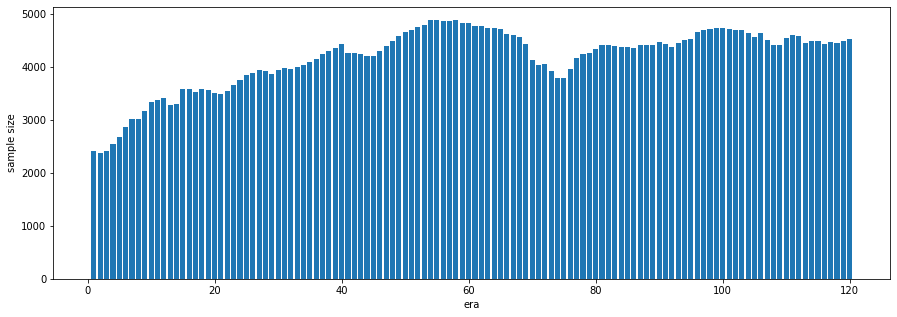

In [27]:
_ = count_samplesize_by_era(train_data)

### 1.2順位相関の計算

今回，データの数値が5種類しかないため値の順位がタイを多く持つことになる．そのような場合に順位相関を計算する時は計算に工夫が必要で，例えば，変数X,Yのデータが次のようであったとする，

| X | Y |
|---|---|
| 1 | 5 |
| 0 | 5 |
| 2 | 4 |
| 1 | 1 |
| 1 | 5 |
| 1 | 3 |

この時，タイ順位に対して出現順に

```
rank_X = [2,6,1,3,4,5]
rank_Y = [1,2,4,6,3,5]
```

と順位を振る方法では，相関係数が変数の並び順に影響を受けてしまう．そこで，タイ順位に対しては平等に順位の平均を割り当てる．例えば，Xの"1"という値は2~5位のため,その平均である3.5が順位として割り当てられる．従って，

```
rank_X = [3.5,6,1,3.5,3.5,3.5]
rank_Y = [2,2,3,6,2,5]
```

と順位をふり，順位相関は次のように計算できる．

```python
rank_x = np.array([3.5, 6, 1, 3.5, 3.5, 3.5])
rank_y = np.array([2, 2, 4, 6, 2, 5])
mean_x = np.mean(rank_x)
mean_y = np.mean(rank_y)
mean_xx = np.mean(rank_x*rank_x)
mean_yy = np.mean(rank_y*rank_y)
mean_xy = np.mean(rank_x*rank_y)
corr = (mean_xy - mean_x*mean_y) / (np.sqrt(mean_xx - mean_x**2)*np.sqrt(mean_yy - mean_y**2))
print(corr)
```

```python
###出力###
-0.35921060405354993
```


- 参考：[Spearman 相関係数を計算するときの注意点](https://qiita.com/PND/items/f368ebaee72df18dd10d)

In [100]:
def mean_rank(sorted_x, argsort_x):
    latest_value = sorted_x[0]
    latest_rank = 1
    same_value_rank_list = [argsort_x[0]] # タイ順位のリスト
    mean_rank_x = -np.ones_like(sorted_x).astype(np.float32)
    for i in range(1,len(sorted_x)):
        x = sorted_x[i]
        if x != latest_value:
            mean = (latest_rank + i) / 2 if i != 1 else 1
            mean_rank_x[same_value_rank_list] = mean
            latest_value = x
            latest_rank = i + 1
            same_value_rank_list = [argsort_x[i]]
        else:
            same_value_rank_list.append(argsort_x[i])
    mean = (latest_rank + len(sorted_x)) / 2
    mean_rank_x[same_value_rank_list] = mean
    
    return mean_rank_x

def calc_spearman_corr(x, y):
    
    #---
    # 配列を降順にソート
    #---
    
    sorted_x = -np.sort(-x)
    # 降順にするために-xをソートする
    sorted_y = -np.sort(-y)
    argsort_x = np.argsort(-x)
    argsort_y = np.argsort(-y)
    
    #---
    # 順位を算出
    #---
    
    rank_x = mean_rank(sorted_x, argsort_x)
    rank_y = mean_rank(sorted_y, argsort_y)
    
    
    #---
    # 順位相関係数を計算
    #---
    
    mean_x = np.mean(rank_x)
    mean_y = np.mean(rank_y)
    mean_xx = np.mean(rank_x*rank_x)
    mean_yy = np.mean(rank_y*rank_y)
    mean_xy = np.mean(rank_x*rank_y)
    corr = (mean_xy - mean_x*mean_y) / \
           (np.sqrt(mean_xx - mean_x**2)*np.sqrt(mean_yy - mean_y**2))
    
    return corr
    
# -> 以後utils.diagnosisから呼び出す

有意な相関を持つ特徴量は存在しなそう．

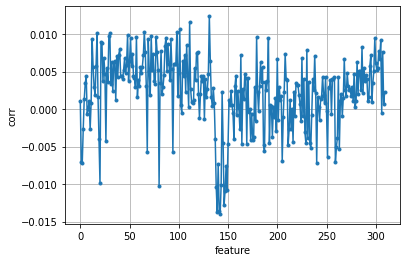

In [104]:
# 各特徴量と目的値との順位相関を計算
corr_list = []
target = train_data['target'].values
for feature_name in feature_names:
    feature = train_data[feature_name].values
    corr = calc_spearman_corr(feature, target)
    corr_list.append(corr)
fig, ax = plt.subplots()
ax.grid()
ax.plot(corr_list,
        marker='.', markersize=6)
ax.set(xlabel='feature', ylabel='corr')
plt.show()